In [84]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline
)
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)

texturing_pipe = TexturingPipeline(pipe.vae, pipe.text_encoder, pipe.tokenizer, pipe.unet, pipe.scheduler, pipe.controlnet)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

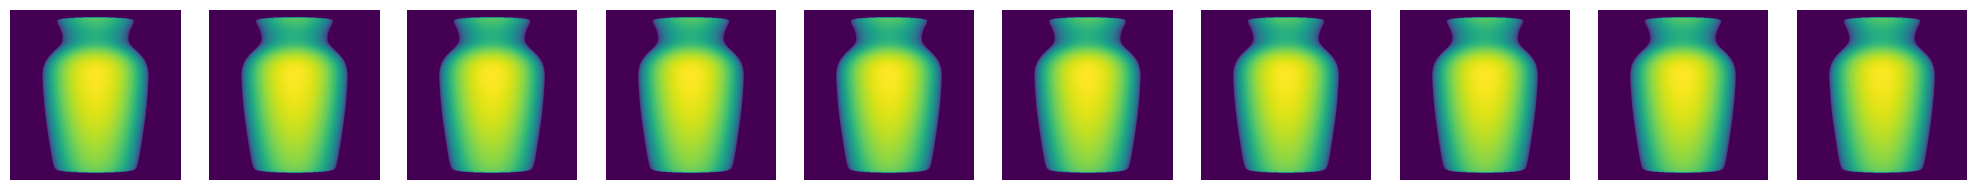

In [86]:
import torch
from pytorch3d.io import load_obj, load_objs_as_meshes

from text3d2video.utilities.camera_placement import (
    turntable_extrinsics,
)
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.mesh_processing import normalize_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/vase.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

n_frames = 10
dist = 6.5

angles = [0, 50]
angles = torch.linspace(0, 180, 10)

R, T = turntable_extrinsics(dists=dist, angles=angles)

view_cam = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
frame_meshes = mesh.extend(len(view_cam))

depths = render_depth_map(frame_meshes, view_cam)

display_ims(depths)

In [87]:
from text3d2video.utilities.camera_placement import cam_view_prompt

prompt_suffixes = []
for angle in angles:
    view = cam_view_prompt(angle, 0)
    prompt_suffixes.append(f", {view} view")

In [ ]:
from pathlib import Path
from text3d2video.noise_initialization import (
    FixedNoiseInitializer,
    RandomNoiseInitializer,
    UVNoiseInitializer,
)
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.utilities.logging import GrLogger

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=0.0,
    chunk_size=5,
    num_keyframes=5,
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=2.0,
    module_paths=module_paths,
)

prompt = "Delft Vase"

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

kf_generator = torch.Generator(device="cuda")
kf_generator.manual_seed(1)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=10)
logger.delete_data()
logger.open_write()
logger.enabled = True

noise_initializer = FixedNoiseInitializer()
noise_initializer = RandomNoiseInitializer()
noise_initializer = UVNoiseInitializer(noise_texture_res=200)

video_frames = pipe(
    prompt,
    frame_meshes,
    view_cam,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=gr_config,
    noise_initializer=noise_initializer,
    generator=generator,
    kf_generator=kf_generator,
    logger=logger,
    prompt_suffixes=prompt_suffixes,
)

 67%|██████▋   | 10/15 [01:29<00:49,  9.87s/it]

In [93]:
from text3d2video.utilities.ipython_utils import display_vid


display_vid(pil_frames_to_clip(video_frames))

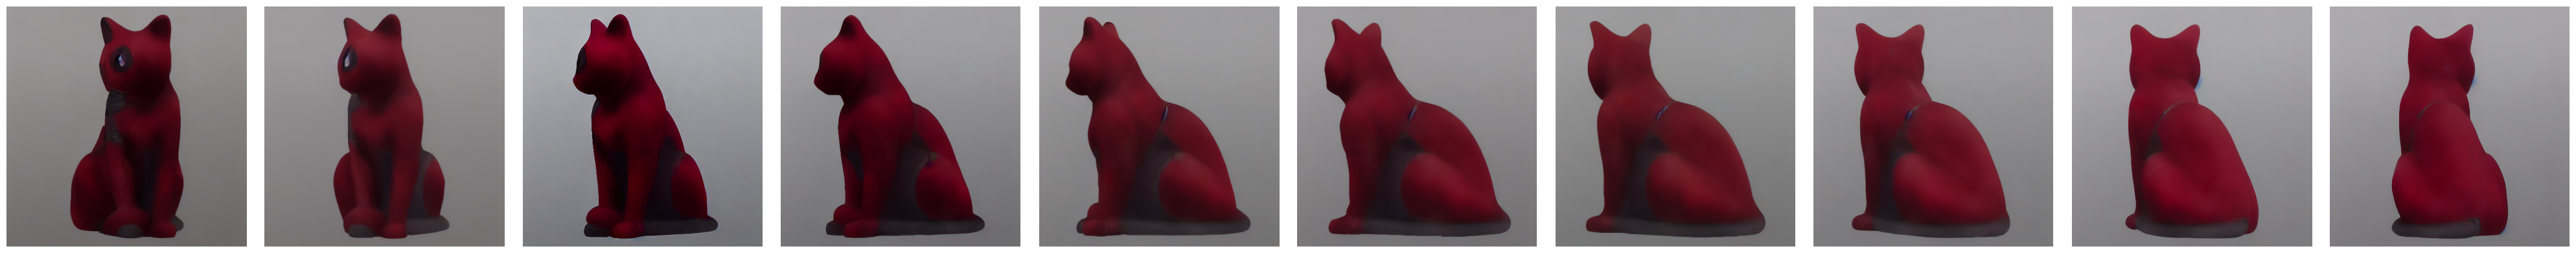

In [81]:
from text3d2video.utilities.ipython_utils import display_ims_grid

display_ims_grid([video_frames], scale=4)

In [74]:
from text3d2video.pipelines.texturing_pipeline import TexturingConfig


generator = torch.Generator(device="cuda")
generator.manual_seed(0)

texture_conf = TexturingConfig(
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

video_frames = texturing_pipe(
    [prompt] * len(frame_meshes),
    frame_meshes,
    view_cam,
    verts_uvs,
    faces_uvs,
    conf=texture_conf,
    generator=generator,
)

100%|██████████| 15/15 [00:49<00:00,  3.33s/it]


In [75]:
from text3d2video.utilities.ipython_utils import display_vid


display_vid(pil_frames_to_clip(video_frames))